In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [3]:
# Upload all datasets
word_recognition = pd.read_csv("filtered_word_recognition_lc_flag.csv")
word_categorization = pd.read_csv("filtered_word_categorization.csv") 

In [8]:
word_recognition

,user_id,voucher,valid,language,lc_flag_x,word,given_response_choice_old_new,given_response_choice_alive_manmade,wasOld_new,was_in_alive_manmade_list,recover_lc_flag
0,10150,1,1,0,Null,OYSTER,2,NaN,0,0.0,True
1,10150,1,1,0,Null,OYSTER,2,NaN,0,0.0,True
2,10150,1,1,0,Null,OYSTER,2,NaN,0,0.0,True
3,10150,1,1,0,Null,BEE,4,4.0,0,0.0,True
4,10150,1,1,0,Null,BEE,4,4.0,0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...
47995,10486,1,1,0,Null,HORSE,2,NaN,0,0.0,False
47996,10486,1,1,0,Null,CANNON,2,NaN,1,NaN,False
47997,10486,1,1,0,Null,FOX,2,NaN,1,NaN,False
47998,10486,1,1,0,Null,HERB,4,4.0,0,0.0,False


In [9]:
print(word_recognition["recover_lc_flag"].unique())

[ True False]


# 1. ACC and WR_Information by categories

Calculate the accuracy or precision of the users, taken from the percentage calculated from the ‘wc_percents’ table.

The results represent the following:
- If ACC = 1 (100%) -> The user answered all words correctly.
- If ACC = 0.5 (50%) -> The user got half of the words right.
- If ACC ≈ 0.0 -> The user performed very poorly.

In [4]:
# Define the Shannon Information function
def shannon_information(acc):
    if acc == 0:  # If accuracy is 0, return -1
        return -1
    elif acc == 1:  # If accuracy is 1, return 1
        return 1
    return np.sign(acc - 0.5) * (
        acc * np.log2(2 * acc) + (1 - acc) * np.log2(2 * (1 - acc))
    )

In [6]:
# Function to evaluate correct answers in Old-New
def is_correct_response_old_new(row):
    if row['given_response_choice_old_new'] == 3:  # Ambiguous, we ignore it
        return None  
    if row['wasOld_new'] == 1:  # Old word
        return row['given_response_choice_old_new'] in [4, 5]
    elif row['wasOld_new'] == 0:  # New word
        return row['given_response_choice_old_new'] in [1, 2]
    return False

In [7]:
# Function to evaluate correct answers in Alive-Manmade
def is_correct_response_alive_manmade(row):
    if pd.isna(row['given_response_choice_alive_manmade']):  # If there is no response, we ignore
        return None
    if row['given_response_choice_alive_manmade'] == 3.0:  # Ambiguous, we ignore it
        return None  
    if row['was_in_alive_manmade_list'] == 1:  # It's really Alive
        return row['given_response_choice_alive_manmade'] in [1.0, 2.0]
    elif row['was_in_alive_manmade_list'] == 0:  # It's really Manmade
        return row['given_response_choice_alive_manmade'] in [4.0, 5.0]
    return False

In [8]:
# Apply the functions to both classifications
word_recognition['is_correct_old_new'] = word_recognition.apply(is_correct_response_old_new, axis=1)
word_recognition['is_correct_alive_manmade'] = word_recognition.apply(is_correct_response_alive_manmade, axis=1)

# Filter by eliminating ambiguous answers
df_filtered = word_recognition.dropna(subset=['is_correct_old_new', 'is_correct_alive_manmade'], how='all')

# Calculate ACC per user for both ratings
user_acc = df_filtered.groupby('user_id')[['is_correct_old_new', 'is_correct_alive_manmade']].mean().reset_index()
user_acc.columns = ['user_id', 'ACC_Old_New', 'ACC_Alive_Manmade']

# Calculate WR_information for both classifications
user_acc['WR_information_Old_New'] = user_acc['ACC_Old_New'].apply(shannon_information)
user_acc['WR_information_Alive_Manmade'] = user_acc['ACC_Alive_Manmade'].apply(shannon_information)

user_acc

,user_id,ACC_Old_New,ACC_Alive_Manmade,WR_information_Old_New,WR_information_Alive_Manmade
0,103,0.592965,0.400000,0.025083,-0.029049
1,104,0.132530,0.583333,-0.435664,0.020131
2,105,0.404494,0.470588,-0.026481,-0.002497
3,1012,0.170330,0.480000,-0.341542,-0.001154
4,1014,0.066667,0.672269,-0.646641,0.087409
...,...,...,...,...,...
181,10435,0.083333,0.547009,-0.586183,0.006386
182,10436,0.350000,0.333333,-0.065932,-0.081704
183,10437,0.189944,0.490566,-0.298645,-0.000257
184,10440,0.215000,0.487395,-0.249068,-0.000458


In [21]:
# Save the DataFrame to a CSV file
user_acc.to_csv("WR_ACC_info_byCatergory.csv", index=False)

print("Dataset saved successfully as 'WR_ACC_info_byCatergory.csv'.")

Dataset saved successfully as 'WR_ACC_info_byCatergory.csv'.


# 2. Explicit and implicit answers (%)

In [9]:
# Count user responses for different choices in Old-New and Alive-Manmade
response_counts_old_new = word_recognition.groupby("user_id")["given_response_choice_old_new"].value_counts().unstack(fill_value=0)
response_counts_alive_manmade = word_recognition.groupby("user_id")["given_response_choice_alive_manmade"].value_counts().unstack(fill_value=0)

# Function to categorize implicit and explicit correctness
def categorize_responses(row):
    total_responses = row.sum()  # Total responses from the user
    if total_responses == 0:
        return pd.Series([0, 0, 0, 0], index=["Implicit_Correct", "Implicit_Wrong", "Explicit_Correct", "Explicit_Wrong"])

    # Calculate Correct percentages
    implicit_correct = ((row.get(4, 0) + row.get(2, 0)) / total_responses) * 100  # Probably Old or Probably New (Correct)
    explicit_correct = ((row.get(5, 0) + row.get(1, 0)) / total_responses) * 100  # I'm sure it's Old or I'm sure it's New (Correct)

    # Calculate Wrong as (100 - Correct)
    implicit_wrong = 100 - implicit_correct
    explicit_wrong = 100 - explicit_correct

    return pd.Series([implicit_correct, implicit_wrong, explicit_correct, explicit_wrong],
                     index=["Implicit_Correct", "Implicit_Wrong", "Explicit_Correct", "Explicit_Wrong"])

# Apply categorization function for Old-New and Alive-Manmade
implicit_explicit_results_old_new = response_counts_old_new.apply(categorize_responses, axis=1)
implicit_explicit_results_alive_manmade = response_counts_alive_manmade.apply(categorize_responses, axis=1)

In [10]:
# Rename columns to differentiate Old-New and Alive-Manmade categories
implicit_explicit_results_old_new = implicit_explicit_results_old_new.add_suffix("_OldNew")
implicit_explicit_results_alive_manmade = implicit_explicit_results_alive_manmade.add_suffix("_AliveManmade")

# Merge both DataFrames by user_id (index)
df_combined = implicit_explicit_results_old_new.merge(
    implicit_explicit_results_alive_manmade, 
    left_index=True, 
    right_index=True, 
    how="outer"
)

# Reset index to keep user_id as a column
df_combined.reset_index(inplace=True)

# Select only 'user_id' and 'recover_lc_flag' column from word_recognition dataset
df_lc_flag = word_recognition[["user_id", "recover_lc_flag"]].drop_duplicates()

# Rename 'recover_lc_flag' to 'lc_flag'
df_lc_flag.rename(columns={"recover_lc_flag": "lc_flag"}, inplace=True)

# Merge with df_combined to keep 'lc_flag' column
df_combined = df_combined.merge(df_lc_flag, on="user_id", how="left")

df_combined

,user_id,Implicit_Correct_OldNew,Implicit_Wrong_OldNew,Explicit_Correct_OldNew,Explicit_Wrong_OldNew,Implicit_Correct_AliveManmade,Implicit_Wrong_AliveManmade,Explicit_Correct_AliveManmade,Explicit_Wrong_AliveManmade,lc_flag
0,103,7.0,93.0,92.5,7.5,0.000000,100.000000,100.000000,0.000000,True
1,104,38.5,61.5,3.0,97.0,96.000000,4.000000,0.000000,100.000000,True
2,105,43.5,56.5,1.0,99.0,82.692308,17.307692,15.384615,84.615385,True
3,1012,0.5,99.5,90.5,9.5,0.000000,100.000000,100.000000,0.000000,True
4,1014,11.0,89.0,49.0,51.0,63.025210,36.974790,36.974790,63.025210,True
...,...,...,...,...,...,...,...,...,...,...
182,10435,18.0,82.0,78.0,22.0,27.500000,72.500000,70.000000,30.000000,False
183,10436,5.0,95.0,95.0,5.0,0.505051,99.494949,99.494949,0.505051,False
184,10437,78.5,21.5,11.0,89.0,85.981308,14.018692,13.084112,86.915888,True
185,10440,3.5,96.5,96.5,3.5,7.563025,92.436975,92.436975,7.563025,False


In [11]:
# save the results
df_combined.to_csv("word_recognition_explicit_implicit.csv", index=False)

# 3. GRAPHS for explicit and implicit answers

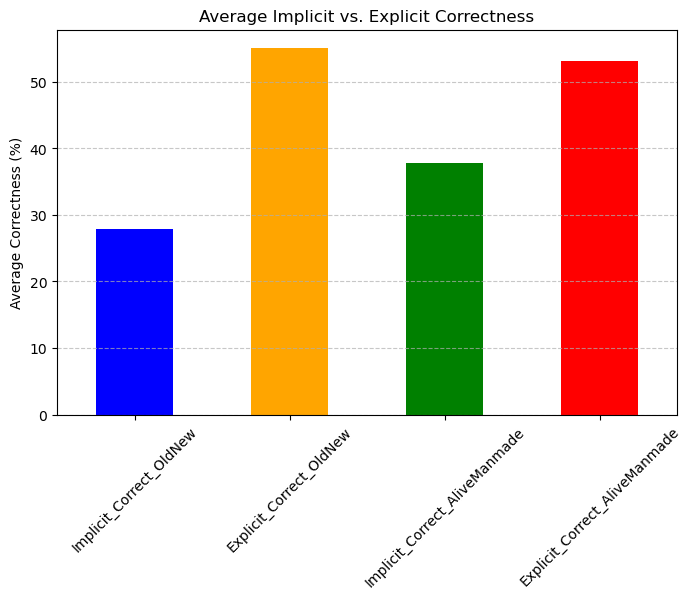

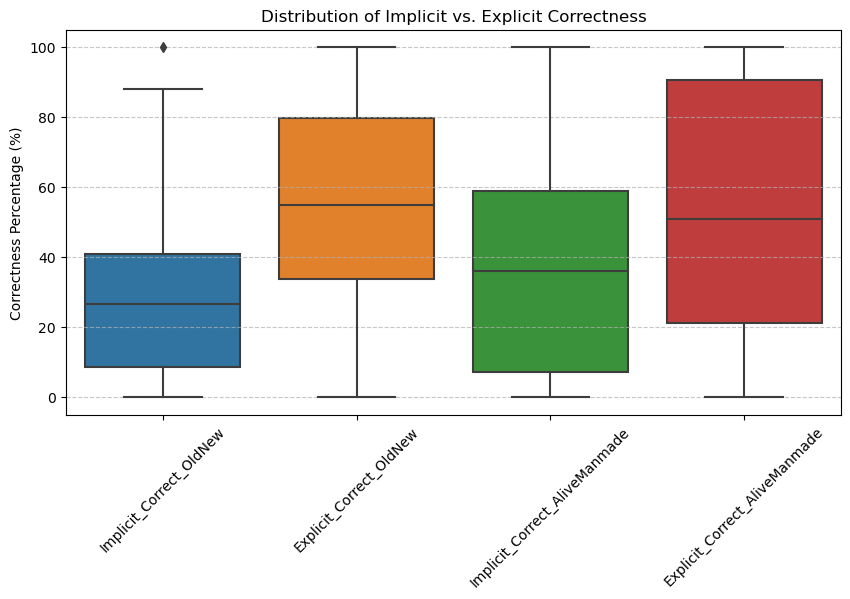

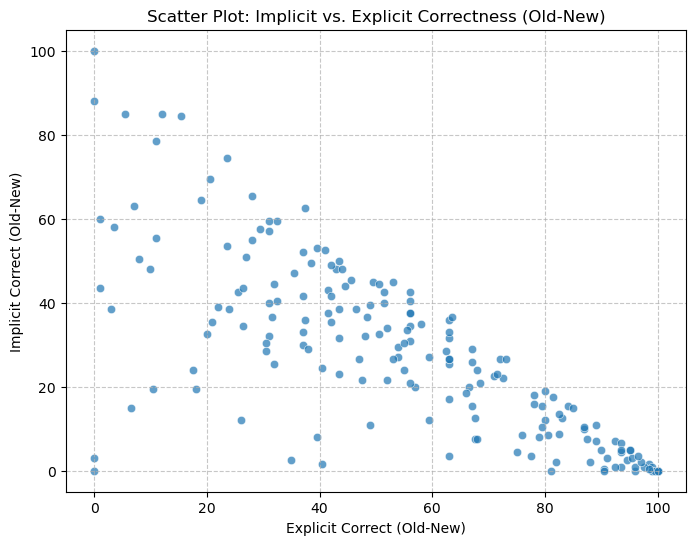

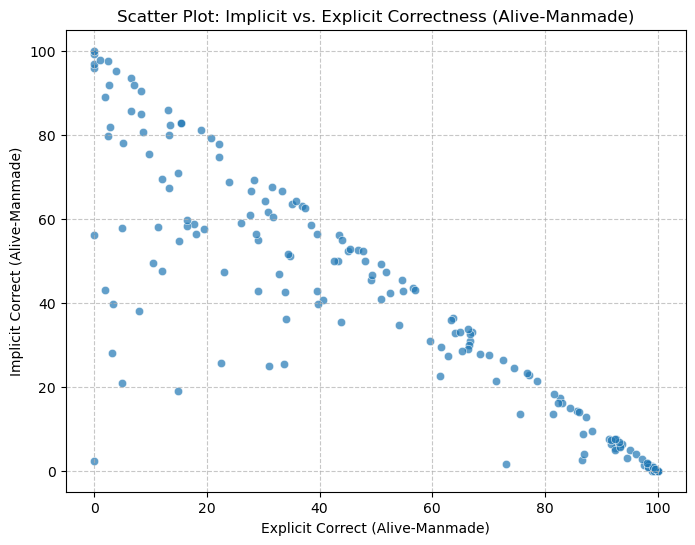

In [38]:
# 1️⃣ Bar Chart: Average Implicit vs. Explicit Correctness
df_avg = df_combined[["Implicit_Correct_OldNew", "Explicit_Correct_OldNew",
                      "Implicit_Correct_AliveManmade", "Explicit_Correct_AliveManmade"]].mean()

plt.figure(figsize=(8, 5))
df_avg.plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
plt.ylabel("Average Correctness (%)")
plt.title("Average Implicit vs. Explicit Correctness")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2️⃣ Boxplot: Spread of Implicit vs. Explicit Performance
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_combined[["Implicit_Correct_OldNew", "Explicit_Correct_OldNew",
                              "Implicit_Correct_AliveManmade", "Explicit_Correct_AliveManmade"]])
plt.title("Distribution of Implicit vs. Explicit Correctness")
plt.ylabel("Correctness Percentage (%)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3️⃣ Scatter Plot: Implicit vs. Explicit Correctness (Old-New)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_combined["Explicit_Correct_OldNew"], y=df_combined["Implicit_Correct_OldNew"], alpha=0.7)
plt.xlabel("Explicit Correct (Old-New)")
plt.ylabel("Implicit Correct (Old-New)")
plt.title("Scatter Plot: Implicit vs. Explicit Correctness (Old-New)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Scatter Plot: Implicit vs. Explicit Correctness (Alive-Manmade)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_combined["Explicit_Correct_AliveManmade"], y=df_combined["Implicit_Correct_AliveManmade"], alpha=0.7)
plt.xlabel("Explicit Correct (Alive-Manmade)")
plt.ylabel("Implicit Correct (Alive-Manmade)")
plt.title("Scatter Plot: Implicit vs. Explicit Correctness (Alive-Manmade)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# 4. GRAPHS by categories

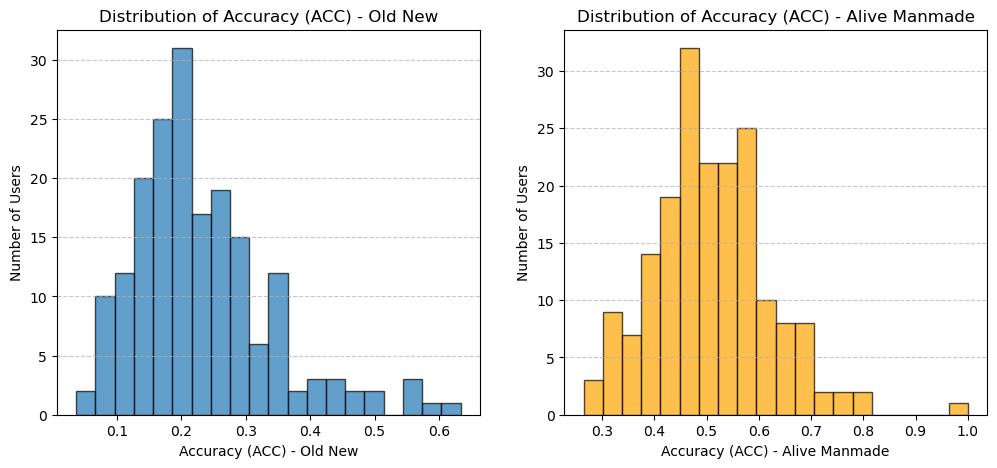

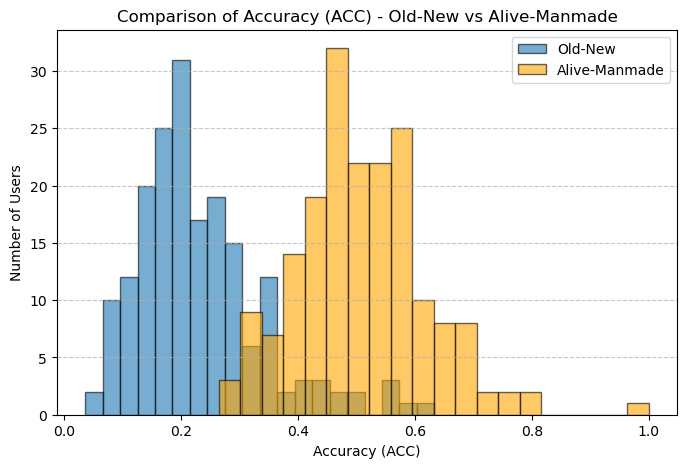

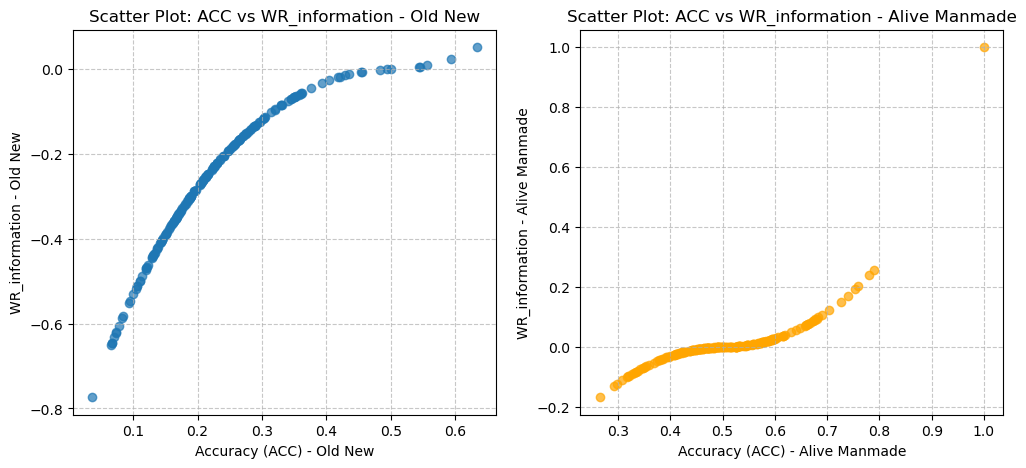

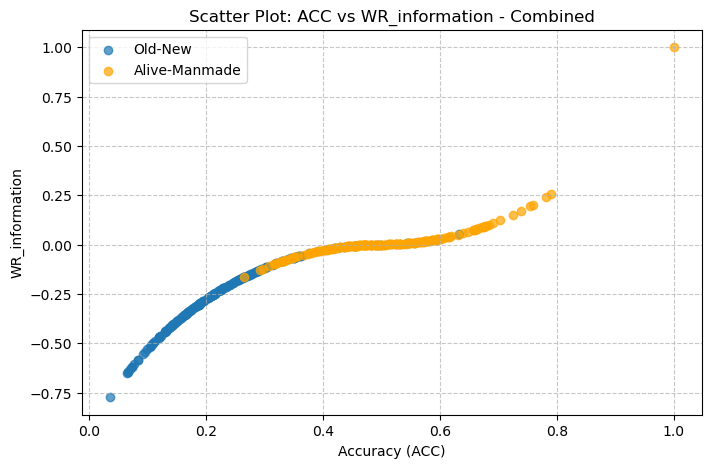

In [8]:
# 1. Separate CCA histograms (Old-New and Alive-Manmade)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(user_acc['ACC_Old_New'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Accuracy (ACC) - Old New')
plt.ylabel('Number of Users')
plt.title('Distribution of Accuracy (ACC) - Old New')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.hist(user_acc['ACC_Alive_Manmade'], bins=20, edgecolor='black', alpha=0.7, color='orange')
plt.xlabel('Accuracy (ACC) - Alive Manmade')
plt.ylabel('Number of Users')
plt.title('Distribution of Accuracy (ACC) - Alive Manmade')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# 2. Combined CCA histogram
plt.figure(figsize=(8, 5))
plt.hist(user_acc['ACC_Old_New'], bins=20, edgecolor='black', alpha=0.6, label="Old-New")
plt.hist(user_acc['ACC_Alive_Manmade'], bins=20, edgecolor='black', alpha=0.6, label="Alive-Manmade", color='orange')
plt.xlabel('Accuracy (ACC)')
plt.ylabel('Number of Users')
plt.title('Comparison of Accuracy (ACC) - Old-New vs Alive-Manmade')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Scatter plots of ACC vs WC_information
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(user_acc['ACC_Old_New'], user_acc['WR_information_Old_New'], alpha=0.7)
plt.xlabel('Accuracy (ACC) - Old New')
plt.ylabel('WR_information - Old New')
plt.title('Scatter Plot: ACC vs WR_information - Old New')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.scatter(user_acc['ACC_Alive_Manmade'], user_acc['WR_information_Alive_Manmade'], alpha=0.7, color='orange')
plt.xlabel('Accuracy (ACC) - Alive Manmade')
plt.ylabel('WR_information - Alive Manmade')
plt.title('Scatter Plot: ACC vs WR_information - Alive Manmade')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

# Combined scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(user_acc['ACC_Old_New'], user_acc['WR_information_Old_New'], alpha=0.7, label="Old-New")
plt.scatter(user_acc['ACC_Alive_Manmade'], user_acc['WR_information_Alive_Manmade'], alpha=0.7, label="Alive-Manmade", color='orange')
plt.xlabel('Accuracy (ACC)')
plt.ylabel('WR_information')
plt.title('Scatter Plot: ACC vs WR_information - Combined')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

<u>Graphical Interpretation:</u>

**1. Separate CCA histograms (Old-New and Alive-Manmade):** They show the distribution of accuracy in each task. It is observed that users in the "Alive-Manmade" task tend to have higher accuracy than in "Old-New".

**2. Combined CCA histogram:** It compares the pressure in both tasks. "Alive-Manmade" has a higher peak accuracy compared to "Old-New".

**3. Scatter plots of ACC vs WC_information:** "Old-New" shows a positive relationship, where more ACC indicates more information processed, while "Alive-Manmade" has a similar relationship, but with more accurate users.

**4. Combined scatter plot:** It compares both tasks in a single graph and also shows that the distribution of "Alive-ManMade" is shifted more to the right (higher accuracy).